# NSL-KDD 데이터 로드 및 전처리(Min-Max Scaling, Quantile Transformation)

In [5]:
import pandas as pd

df_NSL_KDD_train_onehot_quantile = pd.read_csv("NSL-KDD_train_onehot_quantile.csv")
df_NSL_KDD_test_onehot_quantile = pd.read_csv("NSL-KDD_test_onehot_quantile.csv")

df_NSL_KDD_train_onehot_minmax = pd.read_csv("NSL-KDD_train_onehot_minmax.csv")
df_NSL_KDD_test_onehot_minmax = pd.read_csv("NSL-KDD_test_onehot_minmax.csv")

# Autoencoder NSL-KDD Min-Max Scaling

Using device: cpu
NSL-KDD AutoEncoder — OneHot + MinMax
(Validation-based Early Stopping | 스케일링 생략: CSV 이미 전처리됨)

[1] Data Preparation
----------------------------------------------------------------------
✓ Train data shape: (125973, 122)
✓ Test data shape:  (22544, 122)
✓ Train labels - Normal: 67343, Attack: 58630
✓ Test labels  - Normal: 9711,  Attack: 12833
✓ 데이터는 이미 OneHot + MinMaxScaler [0, 1] 범위로 스케일링됨
✓ Normal samples for training: 67343
✓ Train set (80%): 53874 / Validation set (20%): 13469

[2] Training AutoEncoder
----------------------------------------------------------------------
  Model: AutoEncoder
  Structure: 122 -> 16 -> 4 -> 16 -> 122
  Max epochs: 5000, Patience: 20
  Total parameters: 4,190
  Epoch 100: Train=0.004136, Val=0.003395, Best Val=0.003392, Patience=4/20

  ⛔ Early stopping at epoch 194
  Best validation loss: 0.003131
  ✅ Best model restored (Val Loss: 0.003131)

[3] Computing Validation Reconstruction Errors
-----------------------------------------

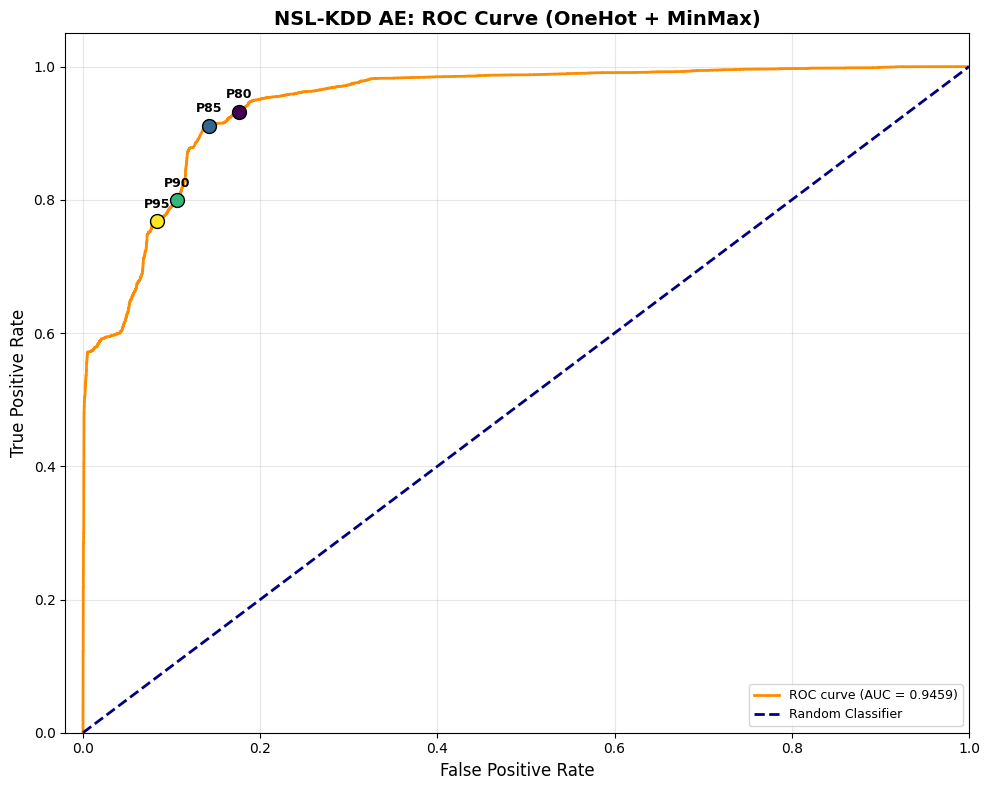

✓ ROC curve plotted

Pipeline Completed Successfully!

📊 Results Preview:
   index  recon_error  pred_P80  pred_P85  pred_P90  pred_P95  label
0      0     0.085955         1         1         1         1      1
1      1     0.085313         1         1         1         1      1
2      2     0.001502         0         0         0         0      0
3      3     0.020466         1         1         1         1      1
4      4     0.054228         1         1         1         1      1
5      5     0.000144         0         0         0         0      0
6      6     0.015318         1         1         1         0      0
7      7     0.019118         1         1         1         1      1
8      8     0.000256         0         0         0         0      0
9      9     0.021093         1         1         1         1      1

📈 Performance Summary:
   Percentile  Threshold  Precision  Sensitivity  Specificity        F1  \
0          80   0.005164   0.875238     0.932596     0.824323  0.903

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, roc_curve, auc
)

# ================================
# 0. Config
# ================================
CFG = {
    "seed": 42,
    "hidden_dim": 16,
    "latent_dim": 4,
    "dropout_rate": 0.2,
    "lr": 1e-3,
    "batch_size": 256,
    "max_epochs": 5000,
    "patience": 20,
    "min_delta": 1e-6,
    "B": 500,
}

# ================================
# 1. Seed & device
# ================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(CFG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================================
# 2. AutoEncoder
# ================================
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, CFG["hidden_dim"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim"], CFG["latent_dim"]),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(CFG["latent_dim"], CFG["hidden_dim"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim"], input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ================================
# 3. Reconstruction error
# ================================
@torch.no_grad()
def reconstruction_error(x, model):
    model.eval()
    errs = []
    for i in range(0, len(x), CFG["batch_size"]):
        xb = x[i:i+CFG["batch_size"]].to(device)
        recon = model(xb)
        err = torch.mean((xb - recon) ** 2, dim=1)
        errs.append(err.cpu())
    return torch.cat(errs).numpy()

# ================================
# 4. Train AE with Validation-based Early Stopping
# ================================
def train_ae(X_train, X_val):
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
        batch_size=CFG["batch_size"],
        shuffle=True
    )
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

    model = AutoEncoder(X_train.shape[1]).to(device)
    opt = optim.Adam(model.parameters(), lr=CFG["lr"])
    loss_fn = nn.MSELoss()

    best_val_loss = np.inf
    patience_counter = 0
    best_state = None

    print(f"  Model: AutoEncoder")
    print(f"  Structure: {X_train.shape[1]} -> {CFG['hidden_dim']} -> {CFG['latent_dim']} -> {CFG['hidden_dim']} -> {X_train.shape[1]}")
    print(f"  Max epochs: {CFG['max_epochs']}, Patience: {CFG['patience']}")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(CFG["max_epochs"]):
        model.train()
        train_loss = 0
        for (xb,) in train_loader:
            xb = xb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), xb)
            loss.backward()
            opt.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(X_train)

        model.eval()
        with torch.no_grad():
            val_recon = model(X_val_tensor.to(device))
            val_loss = loss_fn(val_recon, X_val_tensor.to(device)).item()

        if val_loss < best_val_loss - CFG["min_delta"]:
            improvement = best_val_loss - val_loss
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f} ⬇️ (↓{improvement:.6f})")
        else:
            patience_counter += 1
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Best Val={best_val_loss:.6f}, Patience={patience_counter}/{CFG['patience']}")
            if patience_counter >= CFG["patience"]:
                print(f"\n  ⛔ Early stopping at epoch {epoch+1}")
                print(f"  Best validation loss: {best_val_loss:.6f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"  ✅ Best model restored (Val Loss: {best_val_loss:.6f})")
    else:
        print(f"  ⚠️ Warning: No improvement, using final model")

    return model

# ================================
# 5. Pipeline
# ================================
def run(df_train, df_test):
    print("="*70)
    print("NSL-KDD AutoEncoder — OneHot + MinMax")
    print("(Validation-based Early Stopping | 스케일링 생략: CSV 이미 전처리됨)")
    print("="*70)

    # ----------------------------------------------------------
    # 1. Data Preparation
    #    CSV가 이미 OneHot + MinMax 스케일링 완료된 상태이므로
    #    스케일러 fit/transform 없이 바로 numpy 변환
    # ----------------------------------------------------------
    print("\n[1] Data Preparation")
    print("-"*70)

    X_train = df_train.drop(columns=["class"]).values.astype(np.float32)
    y_train = (df_train["class"] != "normal").astype(int).values
    X_test  = df_test.drop(columns=["class"]).values.astype(np.float32)
    y_test  = (df_test["class"] != "normal").astype(int).values

    print(f"✓ Train data shape: {X_train.shape}")
    print(f"✓ Test data shape:  {X_test.shape}")
    print(f"✓ Train labels - Normal: {(y_train==0).sum()}, Attack: {(y_train==1).sum()}")
    print(f"✓ Test labels  - Normal: {(y_test==0).sum()},  Attack: {(y_test==1).sum()}")
    print(f"✓ 데이터는 이미 OneHot + MinMaxScaler [0, 1] 범위로 스케일링됨")

    X_train_normal = X_train[y_train == 0]
    print(f"✓ Normal samples for training: {X_train_normal.shape[0]}")

    X_tr, X_val = train_test_split(
        X_train_normal, test_size=0.2, random_state=CFG["seed"]
    )
    print(f"✓ Train set (80%): {X_tr.shape[0]} / Validation set (20%): {X_val.shape[0]}")

    # 2. Train
    print("\n[2] Training AutoEncoder")
    print("-"*70)
    model = train_ae(X_tr, X_val)

    # 3. Validation Scores
    print("\n[3] Computing Validation Reconstruction Errors")
    print("-"*70)
    val_scores = reconstruction_error(torch.tensor(X_val, dtype=torch.float32), model)
    print(f"✓ Validation scores — Mean: {val_scores.mean():.6f}, Std: {val_scores.std():.6f}")
    print(f"  Min: {val_scores.min():.6f}, Max: {val_scores.max():.6f}")

    # 4. Bootstrap Percentiles
    print("\n[4] Bootstrap for Threshold Selection")
    print("-"*70)
    target_percentiles = [80, 85, 90, 95]
    rng = np.random.default_rng(CFG["seed"])
    bootstrap_results = []

    print(f"Bootstrapping {CFG['B']} times for percentiles {target_percentiles}...")
    for i in range(CFG["B"]):
        sample = rng.choice(val_scores, size=len(val_scores), replace=True)
        bootstrap_results.append(np.percentile(sample, target_percentiles))
        if (i + 1) % 100 == 0:
            print(f"  Progress: {i+1}/{CFG['B']}")

    bootstrap_results  = np.array(bootstrap_results)
    final_thresholds   = np.median(bootstrap_results, axis=0)

    print("\n✓ Bootstrap completed! Final thresholds (median):")
    for p, th in zip(target_percentiles, final_thresholds):
        print(f"    P{p}: {th:.6f}")

    # 5. Evaluation
    print("\n[5] Test Data Evaluation")
    print("-"*70)
    test_scores = reconstruction_error(torch.tensor(X_test, dtype=torch.float32), model)
    print(f"✓ Test scores — Mean: {test_scores.mean():.6f}, Std: {test_scores.std():.6f}")
    print(f"  Min: {test_scores.min():.6f}, Max: {test_scores.max():.6f}")

    save_data = {"index": np.arange(len(test_scores)), "recon_error": test_scores}

    print("\n" + "="*110)
    print("[TEST PERFORMANCE PER PERCENTILE THRESHOLD]")
    print("="*110)
    print(f"{'Pct(%)':<8} | {'Threshold':<10} | {'Precision':<10} | {'Sensitivity':<12} | {'Specificity':<12} | {'F1':<8} | {'Accuracy':<10} | {'AUC':<8}")
    print("-"*110)

    stats_for_plot = []
    fpr_curve, tpr_curve, _ = roc_curve(y_test, test_scores)
    auc_score = auc(fpr_curve, tpr_curve)

    for p, th in zip(target_percentiles, final_thresholds):
        pred_labels = (test_scores >= th).astype(int)
        save_data[f"pred_P{p}"] = pred_labels

        tn, fp, fn, tp = confusion_matrix(y_test, pred_labels).ravel()
        precision    = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity  = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity  = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1           = f1_score(y_test, pred_labels, zero_division=0)
        acc          = accuracy_score(y_test, pred_labels)
        fpr          = fp / (fp + tn) if (fp + tn) > 0 else 0

        print(f"{p:<8} | {th:.6f}   | {precision:.4f}     | {sensitivity:.4f}       | {specificity:.4f}       | {f1:.4f}   | {acc:.4f}     | {auc_score:.4f}")

        stats_for_plot.append({
            'p': p, 'th': th, 'fpr': fpr, 'tpr': sensitivity,
            'precision': precision, 'sensitivity': sensitivity,
            'specificity': specificity, 'f1': f1, 'acc': acc, 'auc': auc_score
        })

    save_data["label"] = y_test
    result_df = pd.DataFrame(save_data)
    cols_order = ['index', 'recon_error'] + [f'pred_P{p}' for p in target_percentiles] + ['label']
    result_df = result_df[cols_order]

    result_df.to_csv("NSL_KDD_AE_onehot_minmax.csv", index=False)
    print(f"\n✓ Test results saved to 'NSL_KDD_AE_onehot_minmax.csv'  shape: {result_df.shape}")

    performance_df = pd.DataFrame(stats_for_plot)[['p','th','precision','sensitivity','specificity','f1','acc','auc']]
    performance_df.columns = ['Percentile','Threshold','Precision','Sensitivity','Specificity','F1','Accuracy','AUC']
    performance_df.to_csv("NSL_KDD_AE_onehot_minmax_performance.csv", index=False)
    print(f"✓ Performance saved to 'NSL_KDD_AE_onehot_minmax_performance.csv'")

    # 6. ROC Curve
    print("\n[6] ROC Curve Visualization")
    print("-"*70)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_curve, tpr_curve, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    colors = plt.cm.viridis(np.linspace(0, 1, len(stats_for_plot)))
    for i, item in enumerate(stats_for_plot):
        plt.scatter(item['fpr'], item['tpr'], s=100, color=colors[i],
                    edgecolors='black', zorder=5)
        plt.text(item['fpr'], item['tpr'] + 0.02, f"P{item['p']}",
                 fontsize=9, ha='center', fontweight='bold')

    plt.xlim([-0.02, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('NSL-KDD AE: ROC Curve (OneHot + MinMax)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
    print("✓ ROC curve plotted")

    print("\n" + "="*70)
    print("Pipeline Completed Successfully!")
    print("="*70)
    return result_df, performance_df

# ================================
# 6. Execute
# ================================
results, performance = run(df_NSL_KDD_train_onehot_minmax, df_NSL_KDD_test_onehot_minmax)
print("\n📊 Results Preview:");   print(results.head(10))
print("\n📈 Performance Summary:"); print(performance)

# Autoencoder NSL-KDD Qunatile Transformation

Using device: cpu
NSL-KDD AutoEncoder — OneHot + Quantile
(Validation-based Early Stopping | 스케일링 생략: CSV 이미 전처리됨)

[1] Data Preparation
----------------------------------------------------------------------
✓ Train data shape: (125973, 122)
✓ Test data shape:  (22544, 122)
✓ Train labels - Normal: 67343, Attack: 58630
✓ Test labels  - Normal: 9711,  Attack: 12833
✓ 데이터는 이미 OneHot + QuantileTransformer [0, 1] 범위로 스케일링됨
✓ Normal samples for training: 67343
✓ Train set (80%): 53874 / Validation set (20%): 13469

[2] Training AutoEncoder
----------------------------------------------------------------------
  Model: AutoEncoder
  Structure: 122 -> 16 -> 4 -> 16 -> 122
  Max epochs: 5000, Patience: 20
  Total parameters: 4,190
  Epoch 100: Train=0.007155, Val=0.005532, Best Val=0.005512, Patience=3/20
  Epoch 200: Train=0.006831, Val=0.005345, Best Val=0.005295, Patience=5/20

  ⛔ Early stopping at epoch 245
  Best validation loss: 0.005248
  ✅ Best model restored (Val Loss: 0.005248)

[3]

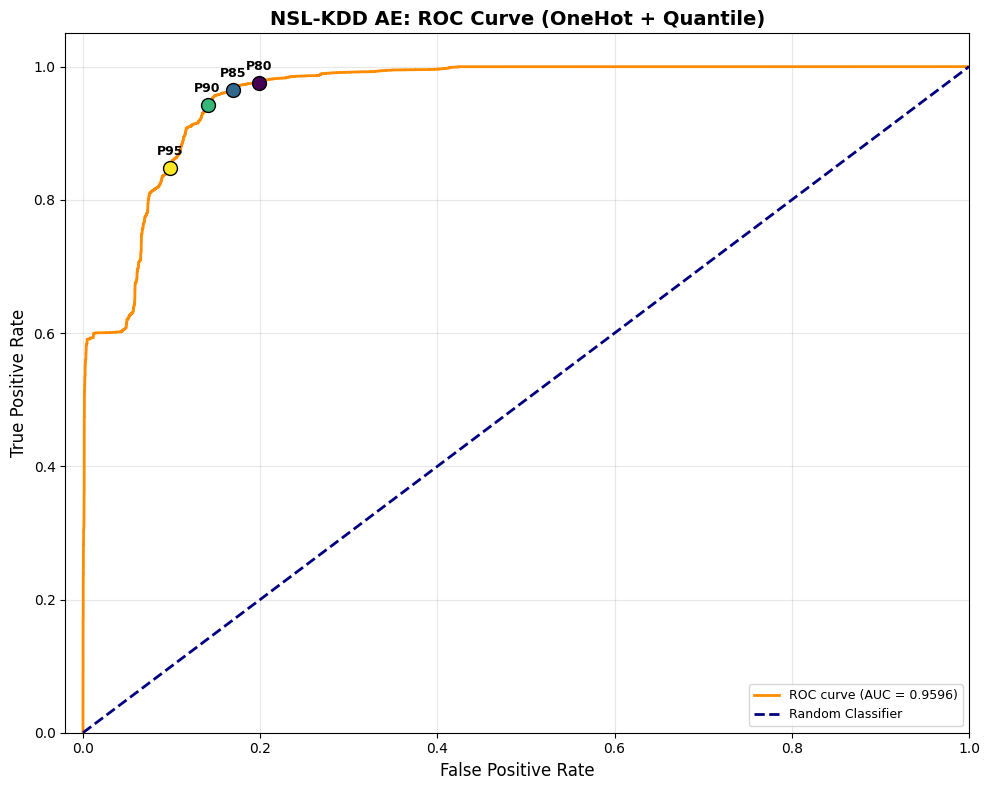

✓ ROC curve plotted

Pipeline Completed Successfully!

📊 Results Preview:
   index  recon_error  pred_P80  pred_P85  pred_P90  pred_P95  label
0      0     0.062549         1         1         1         1      1
1      1     0.067318         1         1         1         1      1
2      2     0.016799         1         1         1         0      0
3      3     0.084878         1         1         1         1      1
4      4     0.053023         1         1         1         1      1
5      5     0.003822         0         0         0         0      0
6      6     0.019272         1         1         1         0      0
7      7     0.054082         1         1         1         1      1
8      8     0.001172         0         0         0         0      0
9      9     0.044798         1         1         1         1      1

📈 Performance Summary:
   Percentile  Threshold  Precision  Sensitivity  Specificity        F1  \
0          80   0.008960   0.866187     0.975532     0.800844  0.917

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, roc_curve, auc
)

# ================================
# 0. Config
# ================================
CFG = {
    "seed": 42,
    "hidden_dim": 16,
    "latent_dim": 4,
    "dropout_rate": 0.2,
    "lr": 1e-3,
    "batch_size": 256,
    "max_epochs": 5000,
    "patience": 20,
    "min_delta": 1e-6,
    "B": 500,
}

# ================================
# 1. Seed & device
# ================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(CFG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================================
# 2. AutoEncoder
# ================================
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, CFG["hidden_dim"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim"], CFG["latent_dim"]),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(CFG["latent_dim"], CFG["hidden_dim"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim"], input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ================================
# 3. Reconstruction error
# ================================
@torch.no_grad()
def reconstruction_error(x, model):
    model.eval()
    errs = []
    for i in range(0, len(x), CFG["batch_size"]):
        xb = x[i:i+CFG["batch_size"]].to(device)
        recon = model(xb)
        err = torch.mean((xb - recon) ** 2, dim=1)
        errs.append(err.cpu())
    return torch.cat(errs).numpy()

# ================================
# 4. Train AE with Validation-based Early Stopping
# ================================
def train_ae(X_train, X_val):
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
        batch_size=CFG["batch_size"],
        shuffle=True
    )
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

    model = AutoEncoder(X_train.shape[1]).to(device)
    opt = optim.Adam(model.parameters(), lr=CFG["lr"])
    loss_fn = nn.MSELoss()

    best_val_loss = np.inf
    patience_counter = 0
    best_state = None

    print(f"  Model: AutoEncoder")
    print(f"  Structure: {X_train.shape[1]} -> {CFG['hidden_dim']} -> {CFG['latent_dim']} -> {CFG['hidden_dim']} -> {X_train.shape[1]}")
    print(f"  Max epochs: {CFG['max_epochs']}, Patience: {CFG['patience']}")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(CFG["max_epochs"]):
        model.train()
        train_loss = 0
        for (xb,) in train_loader:
            xb = xb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), xb)
            loss.backward()
            opt.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(X_train)

        model.eval()
        with torch.no_grad():
            val_recon = model(X_val_tensor.to(device))
            val_loss = loss_fn(val_recon, X_val_tensor.to(device)).item()

        if val_loss < best_val_loss - CFG["min_delta"]:
            improvement = best_val_loss - val_loss
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f} ⬇️ (↓{improvement:.6f})")
        else:
            patience_counter += 1
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Best Val={best_val_loss:.6f}, Patience={patience_counter}/{CFG['patience']}")
            if patience_counter >= CFG["patience"]:
                print(f"\n  ⛔ Early stopping at epoch {epoch+1}")
                print(f"  Best validation loss: {best_val_loss:.6f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"  ✅ Best model restored (Val Loss: {best_val_loss:.6f})")
    else:
        print(f"  ⚠️ Warning: No improvement, using final model")

    return model

# ================================
# 5. Pipeline
# ================================
def run(df_train, df_test):
    print("="*70)
    print("NSL-KDD AutoEncoder — OneHot + Quantile")
    print("(Validation-based Early Stopping | 스케일링 생략: CSV 이미 전처리됨)")
    print("="*70)

    # ----------------------------------------------------------
    # 1. Data Preparation
    #    CSV가 이미 OneHot + QuantileTransformer 스케일링 완료된
    #    상태이므로 스케일러 fit/transform 없이 바로 numpy 변환
    # ----------------------------------------------------------
    print("\n[1] Data Preparation")
    print("-"*70)

    X_train = df_train.drop(columns=["class"]).values.astype(np.float32)
    y_train = (df_train["class"] != "normal").astype(int).values
    X_test  = df_test.drop(columns=["class"]).values.astype(np.float32)
    y_test  = (df_test["class"] != "normal").astype(int).values

    print(f"✓ Train data shape: {X_train.shape}")
    print(f"✓ Test data shape:  {X_test.shape}")
    print(f"✓ Train labels - Normal: {(y_train==0).sum()}, Attack: {(y_train==1).sum()}")
    print(f"✓ Test labels  - Normal: {(y_test==0).sum()},  Attack: {(y_test==1).sum()}")
    print(f"✓ 데이터는 이미 OneHot + QuantileTransformer [0, 1] 범위로 스케일링됨")

    X_train_normal = X_train[y_train == 0]
    print(f"✓ Normal samples for training: {X_train_normal.shape[0]}")

    X_tr, X_val = train_test_split(
        X_train_normal, test_size=0.2, random_state=CFG["seed"]
    )
    print(f"✓ Train set (80%): {X_tr.shape[0]} / Validation set (20%): {X_val.shape[0]}")

    # 2. Train
    print("\n[2] Training AutoEncoder")
    print("-"*70)
    model = train_ae(X_tr, X_val)

    # 3. Validation Scores
    print("\n[3] Computing Validation Reconstruction Errors")
    print("-"*70)
    val_scores = reconstruction_error(torch.tensor(X_val, dtype=torch.float32), model)
    print(f"✓ Validation scores — Mean: {val_scores.mean():.6f}, Std: {val_scores.std():.6f}")
    print(f"  Min: {val_scores.min():.6f}, Max: {val_scores.max():.6f}")

    # 4. Bootstrap Percentiles
    print("\n[4] Bootstrap for Threshold Selection")
    print("-"*70)
    target_percentiles = [80, 85, 90, 95]
    rng = np.random.default_rng(CFG["seed"])
    bootstrap_results = []

    print(f"Bootstrapping {CFG['B']} times for percentiles {target_percentiles}...")
    for i in range(CFG["B"]):
        sample = rng.choice(val_scores, size=len(val_scores), replace=True)
        bootstrap_results.append(np.percentile(sample, target_percentiles))
        if (i + 1) % 100 == 0:
            print(f"  Progress: {i+1}/{CFG['B']}")

    bootstrap_results = np.array(bootstrap_results)
    final_thresholds  = np.median(bootstrap_results, axis=0)

    print("\n✓ Bootstrap completed! Final thresholds (median):")
    for p, th in zip(target_percentiles, final_thresholds):
        print(f"    P{p}: {th:.6f}")

    # 5. Evaluation
    print("\n[5] Test Data Evaluation")
    print("-"*70)
    test_scores = reconstruction_error(torch.tensor(X_test, dtype=torch.float32), model)
    print(f"✓ Test scores — Mean: {test_scores.mean():.6f}, Std: {test_scores.std():.6f}")
    print(f"  Min: {test_scores.min():.6f}, Max: {test_scores.max():.6f}")

    save_data = {"index": np.arange(len(test_scores)), "recon_error": test_scores}

    print("\n" + "="*110)
    print("[TEST PERFORMANCE PER PERCENTILE THRESHOLD]")
    print("="*110)
    print(f"{'Pct(%)':<8} | {'Threshold':<10} | {'Precision':<10} | {'Sensitivity':<12} | {'Specificity':<12} | {'F1':<8} | {'Accuracy':<10} | {'AUC':<8}")
    print("-"*110)

    stats_for_plot = []
    fpr_curve, tpr_curve, _ = roc_curve(y_test, test_scores)
    auc_score = auc(fpr_curve, tpr_curve)

    for p, th in zip(target_percentiles, final_thresholds):
        pred_labels = (test_scores >= th).astype(int)
        save_data[f"pred_P{p}"] = pred_labels

        tn, fp, fn, tp = confusion_matrix(y_test, pred_labels).ravel()
        precision   = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1          = f1_score(y_test, pred_labels, zero_division=0)
        acc         = accuracy_score(y_test, pred_labels)
        fpr         = fp / (fp + tn) if (fp + tn) > 0 else 0

        print(f"{p:<8} | {th:.6f}   | {precision:.4f}     | {sensitivity:.4f}       | {specificity:.4f}       | {f1:.4f}   | {acc:.4f}     | {auc_score:.4f}")

        stats_for_plot.append({
            'p': p, 'th': th, 'fpr': fpr, 'tpr': sensitivity,
            'precision': precision, 'sensitivity': sensitivity,
            'specificity': specificity, 'f1': f1, 'acc': acc, 'auc': auc_score
        })

    save_data["label"] = y_test
    result_df = pd.DataFrame(save_data)
    cols_order = ['index', 'recon_error'] + [f'pred_P{p}' for p in target_percentiles] + ['label']
    result_df = result_df[cols_order]

    result_df.to_csv("NSL_KDD_AE_onehot_quantile.csv", index=False)
    print(f"\n✓ Test results saved to 'NSL_KDD_AE_onehot_quantile.csv'  shape: {result_df.shape}")

    performance_df = pd.DataFrame(stats_for_plot)[['p','th','precision','sensitivity','specificity','f1','acc','auc']]
    performance_df.columns = ['Percentile','Threshold','Precision','Sensitivity','Specificity','F1','Accuracy','AUC']
    performance_df.to_csv("NSL_KDD_AE_onehot_quantile_performance.csv", index=False)
    print(f"✓ Performance saved to 'NSL_KDD_AE_onehot_quantile_performance.csv'")

    # 6. ROC Curve
    print("\n[6] ROC Curve Visualization")
    print("-"*70)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_curve, tpr_curve, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    colors = plt.cm.viridis(np.linspace(0, 1, len(stats_for_plot)))
    for i, item in enumerate(stats_for_plot):
        plt.scatter(item['fpr'], item['tpr'], s=100, color=colors[i],
                    edgecolors='black', zorder=5)
        plt.text(item['fpr'], item['tpr'] + 0.02, f"P{item['p']}",
                 fontsize=9, ha='center', fontweight='bold')

    plt.xlim([-0.02, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('NSL-KDD AE: ROC Curve (OneHot + Quantile)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
    print("✓ ROC curve plotted")

    print("\n" + "="*70)
    print("Pipeline Completed Successfully!")
    print("="*70)
    return result_df, performance_df

# ================================
# 6. Execute
# ================================
results, performance = run(df_NSL_KDD_train_onehot_quantile, df_NSL_KDD_test_onehot_quantile)
print("\n📊 Results Preview:");    print(results.head(10))
print("\n📈 Performance Summary:"); print(performance)

# UNSW-NB15 데이터 로드 및 전처리(Min-Max Scaling, Quantile Transformation)

In [8]:
import pandas as pd

df_UNSW_NB15_train_onehot_quantile = pd.read_csv("UNSW-NB15_train_onehot_quantile.csv")
df_UNSW_NB15_test_onehot_quantile = pd.read_csv("UNSW-NB15_test_onehot_quantile.csv")

df_UNSW_NB15_train_onehot_minmax = pd.read_csv("UNSW-NB15_train_onehot_minmax.csv")
df_UNSW_NB15_test_onehot_minmax = pd.read_csv("UNSW-NB15_test_onehot_minmax.csv")

# Autoencoder UNSW-NB15 Min-Max Scaling

Using device: cpu
UNSW-NB15 AutoEncoder (3-Layer) — OneHot + MinMax
(Validation-based Early Stopping | 스케일링 생략: CSV 이미 전처리됨)

[1] Data Preparation
----------------------------------------------------------------------
✓ Train data shape: (175341, 194)
✓ Test data shape:  (82332, 194)
✓ Train labels - Normal: 56000, Attack: 119341
✓ Test labels  - Normal: 37000,  Attack: 45332
✓ 데이터는 이미 OneHot + MinMaxScaler [0, 1] 범위로 스케일링됨
✓ Normal samples for training: 56000
✓ Train set (80%): 44800 / Validation set (20%): 11200

[2] Training AutoEncoder
----------------------------------------------------------------------
  Model structure: 194 -> 128 -> 64 -> 32 -> 64 -> 128 -> 194
  Max epochs: 5000, Patience: 20
  Total parameters: 70,754
  Epoch 100: Train=0.000926, Val=0.000728 ⬇️ (↓0.000006)
  Epoch 200: Train=0.000592, Val=0.000410 ⬇️ (↓0.000004)
  Epoch 300: Train=0.000483, Val=0.000320, Best Val=0.000321, Patience=1/20
  Epoch 400: Train=0.000422, Val=0.000265, Best Val=0.000264, Patience=

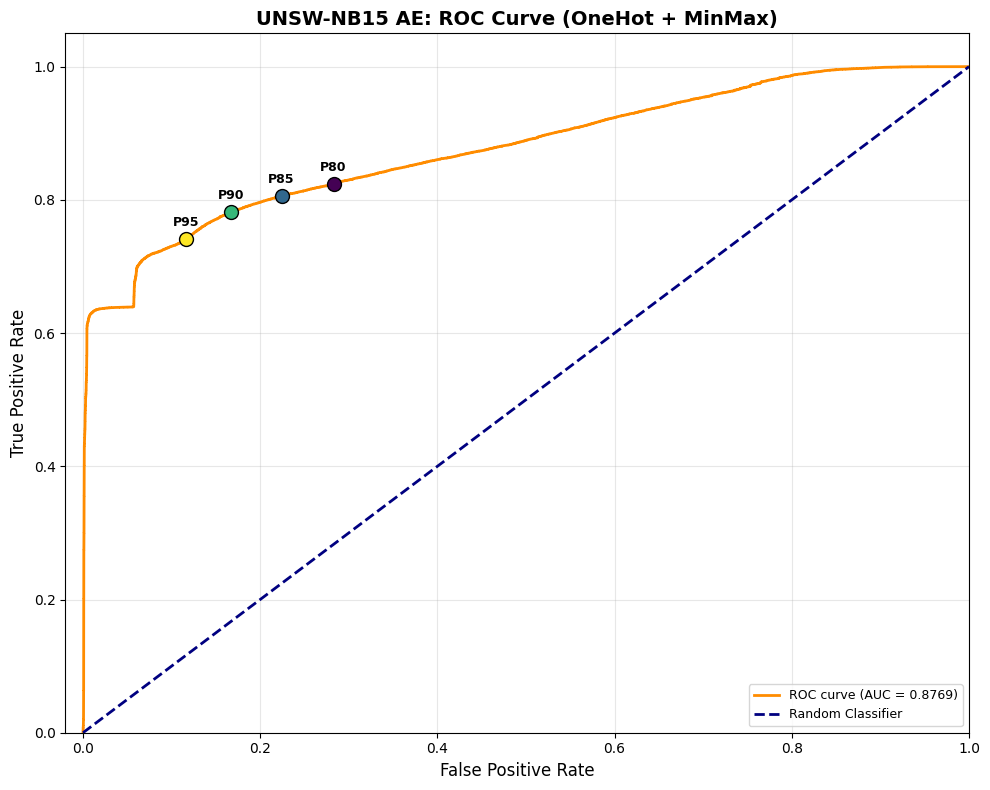

✓ ROC curve plotted

Pipeline Completed Successfully!

📊 Results Preview:
   index  recon_error  pred_P80  pred_P85  pred_P90  pred_P95  label
0      0     0.000029         0         0         0         0      0
1      1     0.000045         0         0         0         0      0
2      2     0.000058         0         0         0         0      0
3      3     0.000022         0         0         0         0      0
4      4     0.000085         0         0         0         0      0
5      5     0.000288         1         1         1         0      0
6      6     0.000134         0         0         0         0      0
7      7     0.000055         0         0         0         0      0
8      8     0.000013         0         0         0         0      0
9      9     0.000013         0         0         0         0      0

📈 Performance Summary:
   Percentile  Threshold  Precision  Sensitivity  Specificity        F1  \
0          80   0.000147   0.781115     0.823899     0.717135  0.801

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, roc_curve, auc
)

# ================================
# 0. Config
# ================================
CFG = {
    "seed": 42,
    "hidden_dim_1": 128,
    "hidden_dim_2": 64,
    "latent_dim": 32,
    "dropout_rate": 0.2,
    "lr": 1e-4,
    "batch_size": 256,
    "max_epochs": 5000,
    "patience": 20,
    "min_delta": 1e-6,
    "B": 500,
}

# ================================
# 1. Seed & device
# ================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(CFG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================================
# 2. AutoEncoder (3-layer)
# ================================
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, CFG["hidden_dim_1"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim_1"], CFG["hidden_dim_2"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim_2"], CFG["latent_dim"]),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(CFG["latent_dim"], CFG["hidden_dim_2"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim_2"], CFG["hidden_dim_1"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim_1"], input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ================================
# 3. Reconstruction error
# ================================
@torch.no_grad()
def reconstruction_error(x, model):
    model.eval()
    errs = []
    for i in range(0, len(x), CFG["batch_size"]):
        xb = x[i:i+CFG["batch_size"]].to(device)
        recon = model(xb)
        err = torch.mean((xb - recon) ** 2, dim=1)
        errs.append(err.cpu())
    return torch.cat(errs).numpy()

# ================================
# 4. Train AE with Validation-based Early Stopping
# ================================
def train_ae(X_train, X_val):
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
        batch_size=CFG["batch_size"],
        shuffle=True
    )
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

    model = AutoEncoder(X_train.shape[1]).to(device)
    opt = optim.Adam(model.parameters(), lr=CFG["lr"])
    loss_fn = nn.MSELoss()

    best_val_loss = np.inf
    patience_counter = 0
    best_state = None

    print(f"  Model structure: {X_train.shape[1]} -> {CFG['hidden_dim_1']} -> {CFG['hidden_dim_2']} -> {CFG['latent_dim']} -> {CFG['hidden_dim_2']} -> {CFG['hidden_dim_1']} -> {X_train.shape[1]}")
    print(f"  Max epochs: {CFG['max_epochs']}, Patience: {CFG['patience']}")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(CFG["max_epochs"]):
        model.train()
        train_loss = 0
        for (xb,) in train_loader:
            xb = xb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), xb)
            loss.backward()
            opt.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(X_train)

        model.eval()
        with torch.no_grad():
            val_recon = model(X_val_tensor.to(device))
            val_loss = loss_fn(val_recon, X_val_tensor.to(device)).item()

        if val_loss < best_val_loss - CFG["min_delta"]:
            improvement = best_val_loss - val_loss
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f} ⬇️ (↓{improvement:.6f})")
        else:
            patience_counter += 1
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Best Val={best_val_loss:.6f}, Patience={patience_counter}/{CFG['patience']}")
            if patience_counter >= CFG["patience"]:
                print(f"\n  ⛔ Early stopping at epoch {epoch+1}")
                print(f"  Best validation loss: {best_val_loss:.6f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"  ✅ Best model restored (Val Loss: {best_val_loss:.6f})")
    else:
        print(f"  ⚠️ Warning: No improvement, using final model")

    return model

# ================================
# 5. Pipeline
# ================================
def run(df_train, df_test):
    print("="*70)
    print("UNSW-NB15 AutoEncoder (3-Layer) — OneHot + MinMax")
    print("(Validation-based Early Stopping | 스케일링 생략: CSV 이미 전처리됨)")
    print("="*70)

    # ----------------------------------------------------------
    # 1. Data Preparation
    #    CSV가 이미 OneHot + MinMaxScaler 스케일링 완료 상태이므로
    #    스케일러 fit/transform 없이 바로 numpy 변환
    # ----------------------------------------------------------
    print("\n[1] Data Preparation")
    print("-"*70)

    X_train = df_train.drop(columns=["label"]).values.astype(np.float32)
    y_train = df_train["label"].values
    X_test  = df_test.drop(columns=["label"]).values.astype(np.float32)
    y_test  = df_test["label"].values

    print(f"✓ Train data shape: {X_train.shape}")
    print(f"✓ Test data shape:  {X_test.shape}")
    print(f"✓ Train labels - Normal: {(y_train==0).sum()}, Attack: {(y_train==1).sum()}")
    print(f"✓ Test labels  - Normal: {(y_test==0).sum()},  Attack: {(y_test==1).sum()}")
    print(f"✓ 데이터는 이미 OneHot + MinMaxScaler [0, 1] 범위로 스케일링됨")

    X_train_normal = X_train[y_train == 0]
    print(f"✓ Normal samples for training: {X_train_normal.shape[0]}")

    X_tr, X_val = train_test_split(
        X_train_normal, test_size=0.2, random_state=CFG["seed"]
    )
    print(f"✓ Train set (80%): {X_tr.shape[0]} / Validation set (20%): {X_val.shape[0]}")

    # 2. Train
    print("\n[2] Training AutoEncoder")
    print("-"*70)
    model = train_ae(X_tr, X_val)

    # 3. Validation Scores
    print("\n[3] Computing Validation Reconstruction Errors")
    print("-"*70)
    val_scores = reconstruction_error(torch.tensor(X_val, dtype=torch.float32), model)
    print(f"✓ Validation scores — Mean: {val_scores.mean():.6f}, Std: {val_scores.std():.6f}")
    print(f"  Min: {val_scores.min():.6f}, Max: {val_scores.max():.6f}")

    # 4. Bootstrap Percentiles
    print("\n[4] Bootstrap for Threshold Selection")
    print("-"*70)
    target_percentiles = [80, 85, 90, 95]
    rng = np.random.default_rng(CFG["seed"])
    bootstrap_results = []

    print(f"Bootstrapping {CFG['B']} times for percentiles {target_percentiles}...")
    for i in range(CFG["B"]):
        sample = rng.choice(val_scores, size=len(val_scores), replace=True)
        bootstrap_results.append(np.percentile(sample, target_percentiles))
        if (i + 1) % 100 == 0:
            print(f"  Progress: {i+1}/{CFG['B']}")

    bootstrap_results = np.array(bootstrap_results)
    final_thresholds  = np.median(bootstrap_results, axis=0)

    print("\n✓ Bootstrap completed! Final thresholds (median):")
    for p, th in zip(target_percentiles, final_thresholds):
        print(f"    P{p}: {th:.6f}")

    # 5. Evaluation
    print("\n[5] Test Data Evaluation")
    print("-"*70)
    test_scores = reconstruction_error(torch.tensor(X_test, dtype=torch.float32), model)
    print(f"✓ Test scores — Mean: {test_scores.mean():.6f}, Std: {test_scores.std():.6f}")
    print(f"  Min: {test_scores.min():.6f}, Max: {test_scores.max():.6f}")

    save_data = {"index": np.arange(len(test_scores)), "recon_error": test_scores}

    print("\n" + "="*110)
    print("[TEST PERFORMANCE PER PERCENTILE THRESHOLD]")
    print("="*110)
    print(f"{'Pct(%)':<8} | {'Threshold':<10} | {'Precision':<10} | {'Sensitivity':<12} | {'Specificity':<12} | {'F1':<8} | {'Accuracy':<10} | {'AUC':<8}")
    print("-"*110)

    stats_for_plot = []
    fpr_curve, tpr_curve, _ = roc_curve(y_test, test_scores)
    auc_score = auc(fpr_curve, tpr_curve)

    for p, th in zip(target_percentiles, final_thresholds):
        pred_labels = (test_scores >= th).astype(int)
        save_data[f"pred_P{p}"] = pred_labels

        tn, fp, fn, tp = confusion_matrix(y_test, pred_labels).ravel()
        precision   = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1          = f1_score(y_test, pred_labels, zero_division=0)
        acc         = accuracy_score(y_test, pred_labels)
        fpr         = fp / (fp + tn) if (fp + tn) > 0 else 0

        print(f"{p:<8} | {th:.6f}   | {precision:.4f}     | {sensitivity:.4f}       | {specificity:.4f}       | {f1:.4f}   | {acc:.4f}     | {auc_score:.4f}")

        stats_for_plot.append({
            'p': p, 'th': th, 'fpr': fpr, 'tpr': sensitivity,
            'precision': precision, 'sensitivity': sensitivity,
            'specificity': specificity, 'f1': f1, 'acc': acc, 'auc': auc_score
        })

    save_data["label"] = y_test
    result_df = pd.DataFrame(save_data)
    cols_order = ['index', 'recon_error'] + [f'pred_P{p}' for p in target_percentiles] + ['label']
    result_df = result_df[cols_order]

    result_df.to_csv("UNSW_NB15_AE_onehot_minmax.csv", index=False)
    print(f"\n✓ Test results saved to 'UNSW_NB15_AE_onehot_minmax.csv'  shape: {result_df.shape}")

    performance_df = pd.DataFrame(stats_for_plot)[['p','th','precision','sensitivity','specificity','f1','acc','auc']]
    performance_df.columns = ['Percentile','Threshold','Precision','Sensitivity','Specificity','F1','Accuracy','AUC']
    performance_df.to_csv("UNSW_NB15_AE_onehot_minmax_performance.csv", index=False)
    print(f"✓ Performance saved to 'UNSW_NB15_AE_onehot_minmax_performance.csv'")

    # 6. ROC Curve
    print("\n[6] ROC Curve Visualization")
    print("-"*70)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_curve, tpr_curve, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    colors = plt.cm.viridis(np.linspace(0, 1, len(stats_for_plot)))
    for i, item in enumerate(stats_for_plot):
        plt.scatter(item['fpr'], item['tpr'], s=100, color=colors[i],
                    edgecolors='black', zorder=5)
        plt.text(item['fpr'], item['tpr'] + 0.02, f"P{item['p']}",
                 fontsize=9, ha='center', fontweight='bold')

    plt.xlim([-0.02, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('UNSW-NB15 AE: ROC Curve (OneHot + MinMax)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
    print("✓ ROC curve plotted")

    print("\n" + "="*70)
    print("Pipeline Completed Successfully!")
    print("="*70)
    return result_df, performance_df

# ================================
# 6. Execute
# ================================
results, performance = run(df_UNSW_NB15_train_onehot_minmax, df_UNSW_NB15_test_onehot_minmax)
print("\n📊 Results Preview:");    print(results.head(10))
print("\n📈 Performance Summary:"); print(performance)

# Autoencoder UNSW-NB15 Quantile Transformation

Using device: cpu
UNSW-NB15 AutoEncoder (3-Layer) — OneHot + Quantile
(Validation-based Early Stopping | 스케일링 생략: CSV 이미 전처리됨)

[1] Data Preparation
----------------------------------------------------------------------
✓ Train data shape: (175341, 194)
✓ Test data shape:  (82332, 194)
✓ Train labels - Normal: 56000, Attack: 119341
✓ Test labels  - Normal: 37000,  Attack: 45332
✓ 데이터는 이미 OneHot + QuantileTransformer [0, 1] 범위로 스케일링됨
✓ Normal samples for training: 56000
✓ Train set (80%): 44800 / Validation set (20%): 11200

[2] Training AutoEncoder
----------------------------------------------------------------------
  Model structure: 194 -> 128 -> 64 -> 32 -> 64 -> 128 -> 194
  Max epochs: 5000, Patience: 20
  Total parameters: 70,754
  Epoch 100: Train=0.002143, Val=0.001705 ⬇️ (↓0.000010)
  Epoch 200: Train=0.001633, Val=0.001232 ⬇️ (↓0.000006)
  Epoch 300: Train=0.001445, Val=0.001058, Best Val=0.001059, Patience=4/20
  Epoch 400: Train=0.001332, Val=0.000958 ⬇️ (↓0.000002)
  Epo

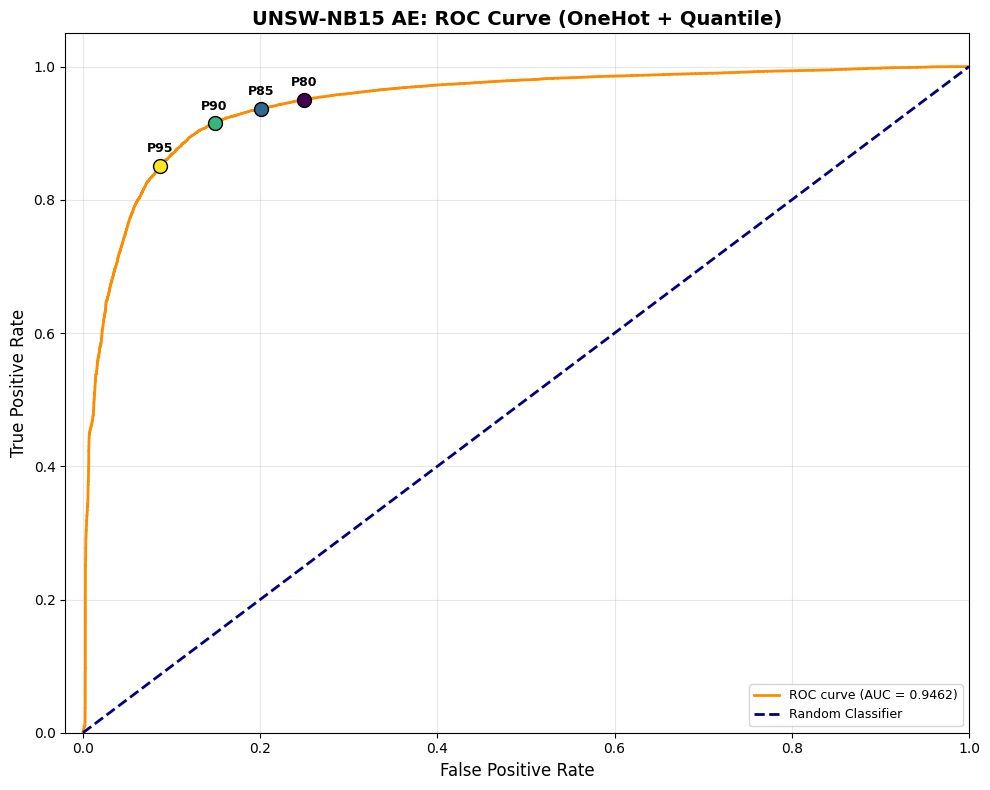

✓ ROC curve plotted

Pipeline Completed Successfully!

📊 Results Preview:
   index  recon_error  pred_P80  pred_P85  pred_P90  pred_P95  label
0      0     0.000264         0         0         0         0      0
1      1     0.000172         0         0         0         0      0
2      2     0.000089         0         0         0         0      0
3      3     0.000430         0         0         0         0      0
4      4     0.000484         0         0         0         0      0
5      5     0.001213         1         1         1         0      0
6      6     0.001094         1         1         1         0      0
7      7     0.000175         0         0         0         0      0
8      8     0.000010         0         0         0         0      0
9      9     0.000010         0         0         0         0      0

📈 Performance Summary:
   Percentile  Threshold  Precision  Sensitivity  Specificity        F1  \
0          80   0.000744   0.823486     0.950300     0.750432  0.882

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, roc_curve, auc
)

# ================================
# 0. Config
# ================================
CFG = {
    "seed": 42,
    "hidden_dim_1": 128,
    "hidden_dim_2": 64,
    "latent_dim": 32,
    "dropout_rate": 0.2,
    "lr": 1e-4,
    "batch_size": 256,
    "max_epochs": 5000,
    "patience": 20,
    "min_delta": 1e-6,
    "B": 500,
}

# ================================
# 1. Seed & device
# ================================
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(CFG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ================================
# 2. AutoEncoder (3-layer)
# ================================
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, CFG["hidden_dim_1"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim_1"], CFG["hidden_dim_2"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim_2"], CFG["latent_dim"]),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(CFG["latent_dim"], CFG["hidden_dim_2"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim_2"], CFG["hidden_dim_1"]),
            nn.ReLU(),
            nn.Dropout(CFG["dropout_rate"]),
            nn.Linear(CFG["hidden_dim_1"], input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ================================
# 3. Reconstruction error
# ================================
@torch.no_grad()
def reconstruction_error(x, model):
    model.eval()
    errs = []
    for i in range(0, len(x), CFG["batch_size"]):
        xb = x[i:i+CFG["batch_size"]].to(device)
        recon = model(xb)
        err = torch.mean((xb - recon) ** 2, dim=1)
        errs.append(err.cpu())
    return torch.cat(errs).numpy()

# ================================
# 4. Train AE with Validation-based Early Stopping
# ================================
def train_ae(X_train, X_val):
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
        batch_size=CFG["batch_size"],
        shuffle=True
    )
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

    model = AutoEncoder(X_train.shape[1]).to(device)
    opt = optim.Adam(model.parameters(), lr=CFG["lr"])
    loss_fn = nn.MSELoss()

    best_val_loss = np.inf
    patience_counter = 0
    best_state = None

    print(f"  Model structure: {X_train.shape[1]} -> {CFG['hidden_dim_1']} -> {CFG['hidden_dim_2']} -> {CFG['latent_dim']} -> {CFG['hidden_dim_2']} -> {CFG['hidden_dim_1']} -> {X_train.shape[1]}")
    print(f"  Max epochs: {CFG['max_epochs']}, Patience: {CFG['patience']}")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(CFG["max_epochs"]):
        model.train()
        train_loss = 0
        for (xb,) in train_loader:
            xb = xb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), xb)
            loss.backward()
            opt.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(X_train)

        model.eval()
        with torch.no_grad():
            val_recon = model(X_val_tensor.to(device))
            val_loss = loss_fn(val_recon, X_val_tensor.to(device)).item()

        if val_loss < best_val_loss - CFG["min_delta"]:
            improvement = best_val_loss - val_loss
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f} ⬇️ (↓{improvement:.6f})")
        else:
            patience_counter += 1
            if (epoch + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Best Val={best_val_loss:.6f}, Patience={patience_counter}/{CFG['patience']}")
            if patience_counter >= CFG["patience"]:
                print(f"\n  ⛔ Early stopping at epoch {epoch+1}")
                print(f"  Best validation loss: {best_val_loss:.6f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"  ✅ Best model restored (Val Loss: {best_val_loss:.6f})")
    else:
        print(f"  ⚠️ Warning: No improvement, using final model")

    return model

# ================================
# 5. Pipeline
# ================================
def run(df_train, df_test):
    print("="*70)
    print("UNSW-NB15 AutoEncoder (3-Layer) — OneHot + Quantile")
    print("(Validation-based Early Stopping | 스케일링 생략: CSV 이미 전처리됨)")
    print("="*70)

    # ----------------------------------------------------------
    # 1. Data Preparation
    #    CSV가 이미 OneHot + QuantileTransformer 스케일링 완료 상태이므로
    #    스케일러 fit/transform 없이 바로 numpy 변환
    # ----------------------------------------------------------
    print("\n[1] Data Preparation")
    print("-"*70)

    X_train = df_train.drop(columns=["label"]).values.astype(np.float32)
    y_train = df_train["label"].values
    X_test  = df_test.drop(columns=["label"]).values.astype(np.float32)
    y_test  = df_test["label"].values

    print(f"✓ Train data shape: {X_train.shape}")
    print(f"✓ Test data shape:  {X_test.shape}")
    print(f"✓ Train labels - Normal: {(y_train==0).sum()}, Attack: {(y_train==1).sum()}")
    print(f"✓ Test labels  - Normal: {(y_test==0).sum()},  Attack: {(y_test==1).sum()}")
    print(f"✓ 데이터는 이미 OneHot + QuantileTransformer [0, 1] 범위로 스케일링됨")

    X_train_normal = X_train[y_train == 0]
    print(f"✓ Normal samples for training: {X_train_normal.shape[0]}")

    X_tr, X_val = train_test_split(
        X_train_normal, test_size=0.2, random_state=CFG["seed"]
    )
    print(f"✓ Train set (80%): {X_tr.shape[0]} / Validation set (20%): {X_val.shape[0]}")

    # 2. Train
    print("\n[2] Training AutoEncoder")
    print("-"*70)
    model = train_ae(X_tr, X_val)

    # 3. Validation Scores
    print("\n[3] Computing Validation Reconstruction Errors")
    print("-"*70)
    val_scores = reconstruction_error(torch.tensor(X_val, dtype=torch.float32), model)
    print(f"✓ Validation scores — Mean: {val_scores.mean():.6f}, Std: {val_scores.std():.6f}")
    print(f"  Min: {val_scores.min():.6f}, Max: {val_scores.max():.6f}")

    # 4. Bootstrap Percentiles
    print("\n[4] Bootstrap for Threshold Selection")
    print("-"*70)
    target_percentiles = [80, 85, 90, 95]
    rng = np.random.default_rng(CFG["seed"])
    bootstrap_results = []

    print(f"Bootstrapping {CFG['B']} times for percentiles {target_percentiles}...")
    for i in range(CFG["B"]):
        sample = rng.choice(val_scores, size=len(val_scores), replace=True)
        bootstrap_results.append(np.percentile(sample, target_percentiles))
        if (i + 1) % 100 == 0:
            print(f"  Progress: {i+1}/{CFG['B']}")

    bootstrap_results = np.array(bootstrap_results)
    final_thresholds  = np.median(bootstrap_results, axis=0)

    print("\n✓ Bootstrap completed! Final thresholds (median):")
    for p, th in zip(target_percentiles, final_thresholds):
        print(f"    P{p}: {th:.6f}")

    # 5. Evaluation
    print("\n[5] Test Data Evaluation")
    print("-"*70)
    test_scores = reconstruction_error(torch.tensor(X_test, dtype=torch.float32), model)
    print(f"✓ Test scores — Mean: {test_scores.mean():.6f}, Std: {test_scores.std():.6f}")
    print(f"  Min: {test_scores.min():.6f}, Max: {test_scores.max():.6f}")

    save_data = {"index": np.arange(len(test_scores)), "recon_error": test_scores}

    print("\n" + "="*110)
    print("[TEST PERFORMANCE PER PERCENTILE THRESHOLD]")
    print("="*110)
    print(f"{'Pct(%)':<8} | {'Threshold':<10} | {'Precision':<10} | {'Sensitivity':<12} | {'Specificity':<12} | {'F1':<8} | {'Accuracy':<10} | {'AUC':<8}")
    print("-"*110)

    stats_for_plot = []
    fpr_curve, tpr_curve, _ = roc_curve(y_test, test_scores)
    auc_score = auc(fpr_curve, tpr_curve)

    for p, th in zip(target_percentiles, final_thresholds):
        pred_labels = (test_scores >= th).astype(int)
        save_data[f"pred_P{p}"] = pred_labels

        tn, fp, fn, tp = confusion_matrix(y_test, pred_labels).ravel()
        precision   = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1          = f1_score(y_test, pred_labels, zero_division=0)
        acc         = accuracy_score(y_test, pred_labels)
        fpr         = fp / (fp + tn) if (fp + tn) > 0 else 0

        print(f"{p:<8} | {th:.6f}   | {precision:.4f}     | {sensitivity:.4f}       | {specificity:.4f}       | {f1:.4f}   | {acc:.4f}     | {auc_score:.4f}")

        stats_for_plot.append({
            'p': p, 'th': th, 'fpr': fpr, 'tpr': sensitivity,
            'precision': precision, 'sensitivity': sensitivity,
            'specificity': specificity, 'f1': f1, 'acc': acc, 'auc': auc_score
        })

    save_data["label"] = y_test
    result_df = pd.DataFrame(save_data)
    cols_order = ['index', 'recon_error'] + [f'pred_P{p}' for p in target_percentiles] + ['label']
    result_df = result_df[cols_order]

    result_df.to_csv("UNSW_NB15_AE_onehot_quantile.csv", index=False)
    print(f"\n✓ Test results saved to 'UNSW_NB15_AE_onehot_quantile.csv'  shape: {result_df.shape}")

    performance_df = pd.DataFrame(stats_for_plot)[['p','th','precision','sensitivity','specificity','f1','acc','auc']]
    performance_df.columns = ['Percentile','Threshold','Precision','Sensitivity','Specificity','F1','Accuracy','AUC']
    performance_df.to_csv("UNSW_NB15_AE_onehot_quantile_performance.csv", index=False)
    print(f"✓ Performance saved to 'UNSW_NB15_AE_onehot_quantile_performance.csv'")

    # 6. ROC Curve
    print("\n[6] ROC Curve Visualization")
    print("-"*70)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_curve, tpr_curve, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    colors = plt.cm.viridis(np.linspace(0, 1, len(stats_for_plot)))
    for i, item in enumerate(stats_for_plot):
        plt.scatter(item['fpr'], item['tpr'], s=100, color=colors[i],
                    edgecolors='black', zorder=5)
        plt.text(item['fpr'], item['tpr'] + 0.02, f"P{item['p']}",
                 fontsize=9, ha='center', fontweight='bold')

    plt.xlim([-0.02, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('UNSW-NB15 AE: ROC Curve (OneHot + Quantile)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
    print("✓ ROC curve plotted")

    print("\n" + "="*70)
    print("Pipeline Completed Successfully!")
    print("="*70)
    return result_df, performance_df

# ================================
# 6. Execute
# ================================
results, performance = run(df_UNSW_NB15_train_onehot_quantile, df_UNSW_NB15_test_onehot_quantile)
print("\n📊 Results Preview:");    print(results.head(10))
print("\n📈 Performance Summary:"); print(performance)